<a href="https://colab.research.google.com/github/qmffkem/learning-micrograd/blob/main/JaeungJang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting to watch video "The spelled-out intro to neural networks and backpropagation: building micrograd" by Andreyj Karpathy.
Link: https://www.youtube.com/watch?v=VMj-3S1tku0

Thanks, Wills for setting this up and thank you everyone who is on the same journey to take this course together! Glad to meet you all. I am farely new to neural networks and any of AI related topics and hope to learn a lot from you all! :)

# 4/13/2024

# Overview
Link:https://www.youtube.com/watch?v=VMj-3S1tku0&t=25s


micrograd: tiny autograd engine

autograd: automatic gradient(?) -> this does backpropagation...

backpropagation: algorithm to efficiently evaluate the gradient of some kind of loss function respect to the weights of neural network

  -> This allows to iteratively tune the weights of the neural network to minimize the loss function and therefore improve the acuracy of the network


---

**Link to micrograd**:https://github.com/karpathy/micrograd

Things defined:
* neuron
* layer
* MLP: multi-layer perceptron == sequence of layers of neurons



# Derivative of a sinmple function with one input

Link:https://www.youtube.com/watch?v=VMj-3S1tku0&t=488s



---



In [83]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
def f(x):
  return 3*x**2 - 4*x + 5

In [85]:
f(3.0)

20.0

In [86]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

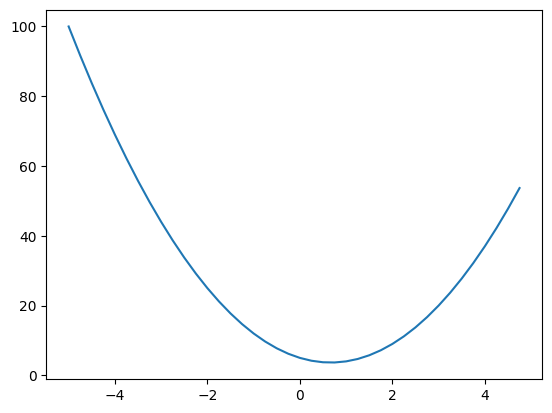

In [87]:
ys = f(xs)
ys
plt.plot(xs, ys)

In [88]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

# Derivative of a function with multiple inputs

Link:https://youtu.be/VMj-3S1tku0?t=873




In [89]:
# let's get more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [90]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/ h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [91]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/ h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


In [92]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/ h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


# 4/14/2024

## Starting the core Value object of micrograd and its visualization

Link:https://youtu.be/VMj-3S1tku0?t=1154

In [186]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # 0 means no effect;
    self._backward = lambda: None  # case for leaf node; there is nothing to do
    self._prev = set(_children)
    self._op = _op
    self.label = label


  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
      for child in v._prev:
        build_topo(child)
      topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [94]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [95]:
d._op

'+'

In [96]:
a * b
# This is same as a.__mul__(b)
# this means that out is Value with -6, and children with self and other
# calling ._prev would give (self, other), which is (Value(data=2.0), Value(data=-3.0))
test = a * b
test._prev

# The ordre is different because of set?

{Value(data=-3.0), Value(data=2.0)}

With children, I can keep track of which values were used to create the current value, and with op, I know which operation was used to generate the current data with the children.

He mentioned that the reason for using set is for the performance optimization.

In [97]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': "LR"}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    #  for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

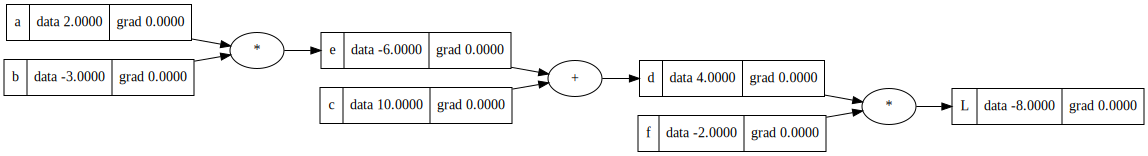

In [98]:
draw_dot(L)

In [99]:
def lol():
  h = 0.001


  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


# 4/15/2024

## manual backpropagation example \#1: simple expression

This sets up the grad manually.
Since there is no change on derivate of L respect to L, we set 1 to it.

for **d** and **f** they become each other after derivative using manual calculation and by testing with by injecting the value.

In [100]:
# manually setting it up here
L.grad = 1.0

# L = d * f        # based on the expression expression above.
                 # if taking derivative on d, grad = f; if on f, grad = d
d.grad = -2.0
f.grad = 4.0

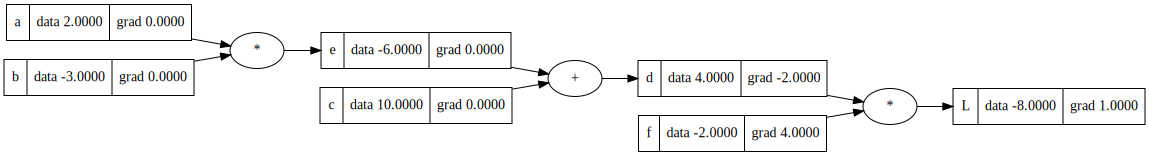

In [101]:
draw_dot(L)

# 4/16/2024


covering how to calculate derivate L respecte to c, and derivative of L respect to e.

This is a bit more comprex than the previous example of d and f.

dd / dc = 1.0

dd / de = 1.0

d = c + e

we want to know how L is affected by the change of c and change of e; derivative of L respect to c and derivate of L respect to e.

we know the local derivative; dL/dd and dL/df from above.

now we know the local derivate as well; dd/dc and dd/de.

what we need here to find the dL/dc or dL/de is the **chain rule**.


**want:**
dL / dc = (dL / dd) * (dd / dc)

**know:**
dL / dd
dd / dc


In [102]:
c.grad = -2.0
e.grad = -2.0


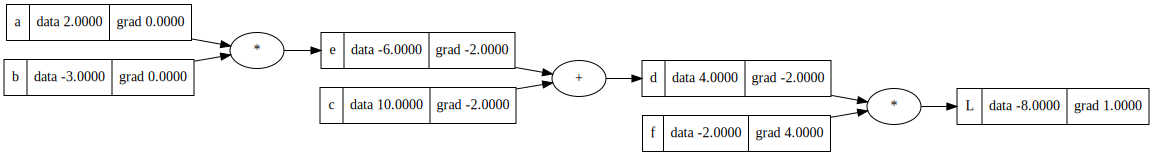

In [103]:
draw_dot(L)

dL / de = -2.0

dL / da = (dL / de) * (de / da)\
        = (-2.0) * (-3.0)\
        = 6.0

dL / db = (dL / de) * (de / db)\
        = (-2.0) * (2.0)\
        = -4.0

In [104]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

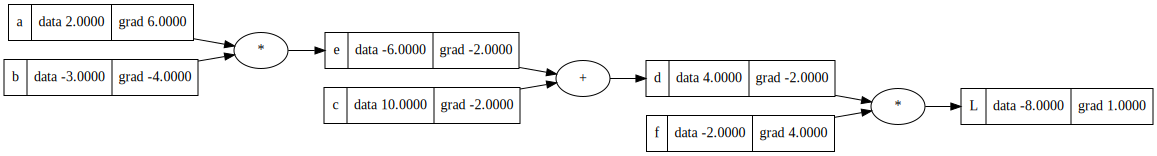

In [105]:
draw_dot(L)

## preview of a single optimixation step

if we want to increase value of L up, we increase the leaf node to the direction of gradient.

In [136]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = f * d

In [137]:
print(L.data)

-47.54549434807817


## manual backpropagation example \#2: a neuron

In [191]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,s2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

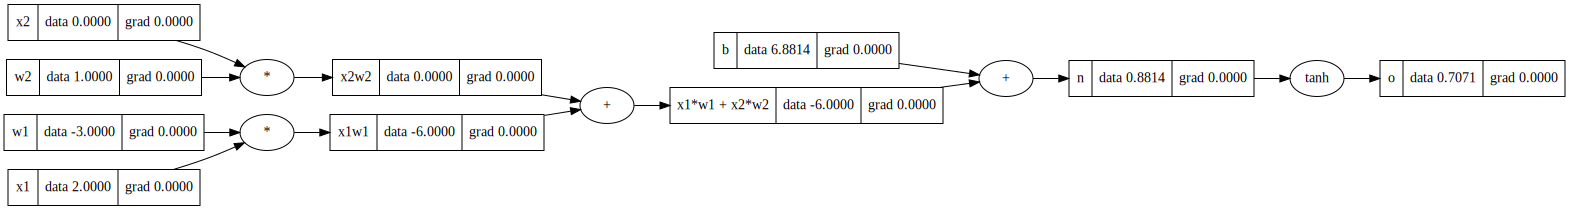

In [192]:
draw_dot(o)

how we just built a single neuron and going to manually feed and set the backpropagation.


In [148]:
o.grad = 1.0
# do/dn = 1 - tanh**2 = 1 - o**2 ; the equation is from wikipedia
n.grad = 0.5

b.grad = 0.5
x1w1x2w2.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

## implementing the backward function for each operation

implemented the logic to perform the manual backpropagation to the **Value** class in a code and run the _backward() function to set the gradient now.

In [168]:
o.grad = 1.0

In [179]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

## implementing the backward function for a whole expression gpaph

the backward fucntion need to be called from the root node and then the childrens follow.

to perform the backward function this order, he implements topological sort, set base case, and call the function with root node.

In [184]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
  for child in v._prev:
    build_topo(child)
  topo.append(v)

build_topo(o)

for node in reversed(topo):
  node._backward()

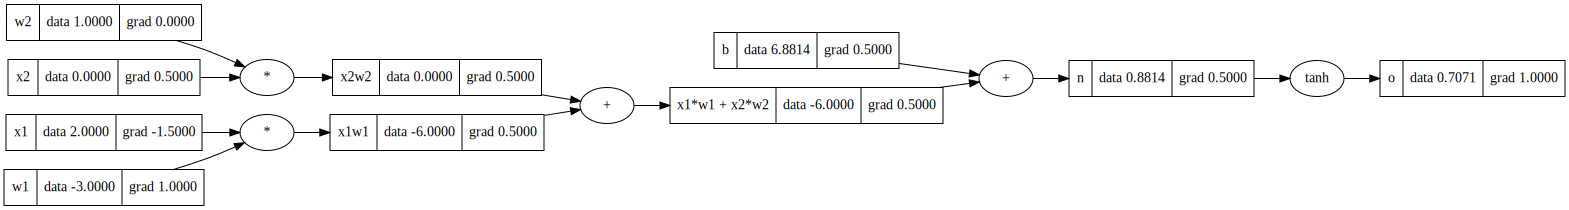

In [185]:
draw_dot(o)

In [195]:
o.backward()

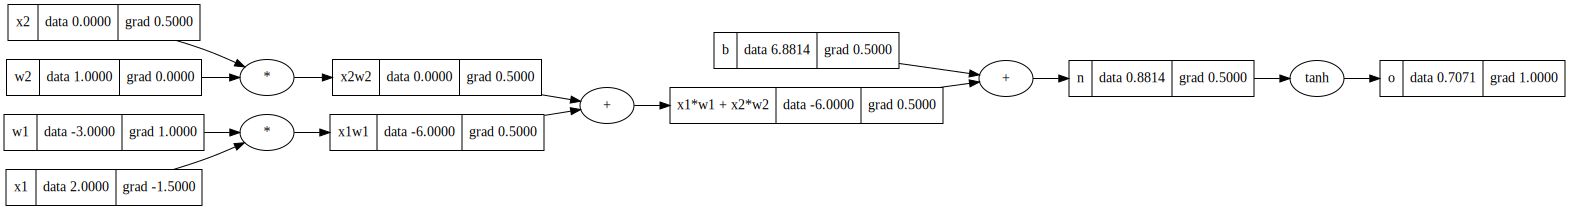

In [196]:
draw_dot(o)